# Maximizing Customer Retention: Fairway Bank (Modeling 1)

We are ready to build some classification models to predict customer churn. Data preprocessing can be found __[here](https://github.com/da42ru/Fairway_Bank_Churn_Reduction/blob/main/notebooks/02_preprocessing.ipynb)__.

## Load Libraries

In [303]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, make_scorer

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

## Load Data

In [306]:
df = pd.read_csv('bank_4.csv', index_col=0)

In [308]:
df.head()

,credit_score,gender,age,tenure,balance,num_products,credit_card,active,salary,churn,...,points,country_F,country_G,country_S,card_D,card_G,card_P,card_S,umap_1,umap_2
0,1,0,2,2,0,1,1,1,2,1,...,2,1,0,0,1,0,0,0,-3.143583,0.786093
1,1,0,2,1,1,1,0,1,2,0,...,2,0,0,1,1,0,0,0,10.020865,-11.832602
2,0,0,2,8,3,3,1,0,2,1,...,1,1,0,0,1,0,0,0,-3.809586,-0.268657
3,2,0,2,1,0,2,0,0,1,0,...,1,1,0,0,0,1,0,0,-8.133482,3.541135
4,3,0,2,2,2,1,1,1,1,0,...,2,0,0,1,0,1,0,0,1.444620,-6.639251


In [310]:
df.shape

(10000, 22)

## Train / Test Split

In [561]:
# We will build initial models without the umap features

X = df.drop(columns=['churn', 'umap_1', 'umap_2'])
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [527]:
print(f'Train shape: {X_train.shape, y_train.shape}')
print(f'Test shape: {X_test.shape, y_test.shape}')

Train shape: ((8000, 19), (8000,))
Test shape: ((2000, 19), (2000,))


## Scoring Metric

As this is a binary classification problem predicting either: retain (0) or churn (1), we consider the following metrics:

- **Accuracy:** number of true predictions divided by total predictions
- **Precision:** number of true positives divided by total predicted positives
- **Recall:** number of true positives divided by total actual positives
- **F1 Score:** harmonic mean of precision and recall

Whereas precision is a good score to use when there is a high cost for false positives (Type 1 error), recall is a good score to use when there is a high cost for false negatives (Type 2 error). Since our goal is to reduce churn of existing customers, our top priority is to minimize false negatives so that we do not miss properly predicting a customer that is likely to churn. This will help us most effectively select customers that are likely to churn to extend additional support to so that they might retain instead. Thus, we will use recall as our primary scoring metric for model comparison.

In [319]:
# Cross-validate model recall on train data

def cv(model):
    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    scores = cross_val_score(model, X_train, y_train, scoring=make_scorer(recall_score), cv=skf, n_jobs=-1)
    print('Cross-validated recall:', np.mean(scores))

In [321]:
# Fit model to train data and predict churn on test data

def pred(model):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    ConfusionMatrixDisplay(confusion_matrix(y_test, preds)).plot(colorbar=False);
    plt.title('Test Predictions')

In [323]:
#Evaluate feature importances

def feat(model):
    model.fit(X_train, y_train)
    fi = pd.DataFrame({'Feature':X_train.columns, 'Importance':model.feature_importances_}).sort_values(
                       'Importance', ascending=False).reset_index(drop=True)
    return fi

## Random Forest Classifier

In [452]:
# Untuned model

rf = RandomForestClassifier(random_state=42)

In [454]:
cv(rf)

Cross-validated recall: 0.9987730061349694


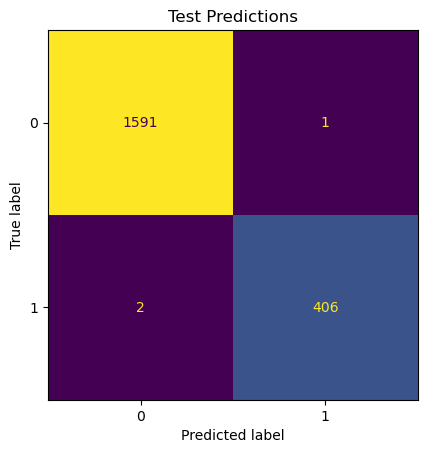

In [456]:
pred(rf)

The model only predicts 2 false negatives and 1 false positive on the test set.

In [333]:
feat(rf)

,Feature,Importance
0,complain,0.812243
1,age,0.058174
2,num_products,0.043070
3,active,0.012829
4,tenure,0.010475
5,country_G,0.010411
6,points,0.008528
7,balance,0.008421
8,satisfaction,0.005926
9,salary,0.005855


Complain is by far the most important feature, followed by age and number of products.

## Extra Trees Classifier

In [337]:
# Untuned model

et = ExtraTreesClassifier(random_state=42)

In [339]:
cv(et)

Cross-validated recall: 0.9987730061349694


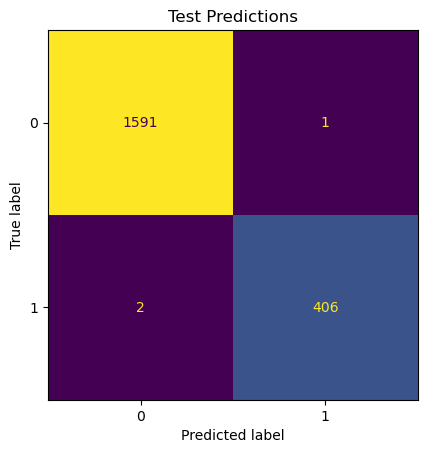

In [341]:
pred(et)

In [343]:
feat(et)

,Feature,Importance
0,complain,0.865663
1,num_products,0.042452
2,age,0.026682
3,active,0.010724
4,country_G,0.008767
5,balance,0.007398
6,tenure,0.005074
7,points,0.004545
8,satisfaction,0.004216
9,country_F,0.003987


Extra trees performs similar to random forest and also rates complain as the most important feature, but it places less emphasis on age.

## Gradient Boosting Classifier

In [347]:
# Untuned model

gb = GradientBoostingClassifier(random_state=42)

In [349]:
cv(gb)

Cross-validated recall: 0.9987730061349694


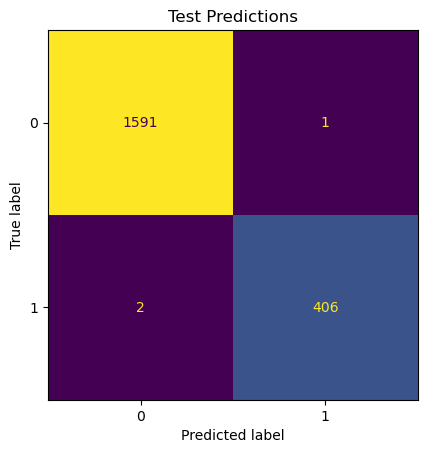

In [351]:
pred(gb)

In [353]:
feat(gb)

,Feature,Importance
0,complain,9.992628e-01
1,age,1.691350e-04
2,num_products,1.435001e-04
3,points,1.143485e-04
4,balance,7.251439e-05
5,satisfaction,6.555484e-05
6,tenure,5.726994e-05
7,active,5.214894e-05
8,country_G,3.341186e-05
9,card_G,1.347894e-05


## Hist Gradient Boosting Classifier

In [356]:
# Untuned model

hgb = HistGradientBoostingClassifier(random_state=42)

In [358]:
cv(hgb)

Cross-validated recall: 0.9987730061349694


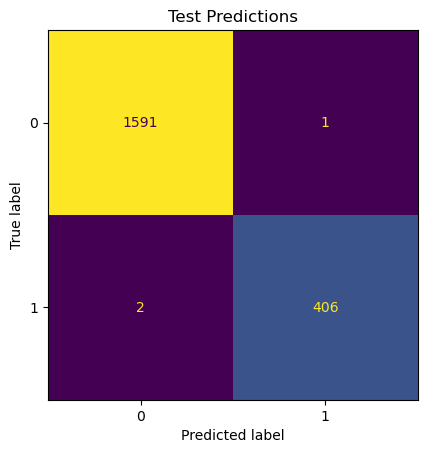

In [360]:
pred(hgb)

## AdaBoost Classifier

In [363]:
# Untuned model

ab = AdaBoostClassifier(random_state=42)

In [365]:
cv(ab)

Cross-validated recall: 0.9963190184049079


This is the first model not to have a train cross-validated recall of 0.9987730061349694.

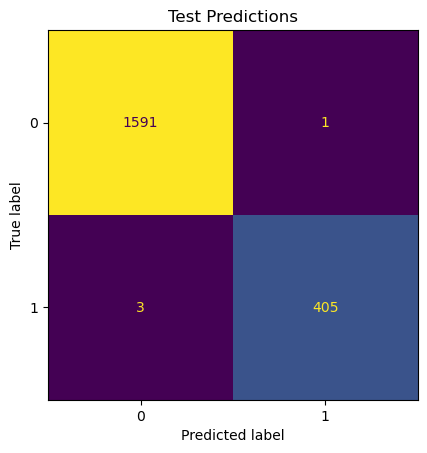

In [368]:
pred(ab)

Like prior models, adaboost has 1 false positive, but 3 false negatives. This is still an excellent performance.

In [371]:
feat(ab)

,Feature,Importance
0,complain,0.20
1,satisfaction,0.14
2,age,0.12
3,tenure,0.12
4,points,0.10
5,balance,0.06
6,num_products,0.06
7,salary,0.06
8,active,0.04
9,country_F,0.02


Adaboost has some different feature importances than prior models. Complain is still the most important, but satisfaction is second most important.

## XGBoost Classifier

In [375]:
# Untuned model

xgb = XGBClassifier(random_state=42)

In [377]:
cv(xgb)

Cross-validated recall: 0.9987730061349694


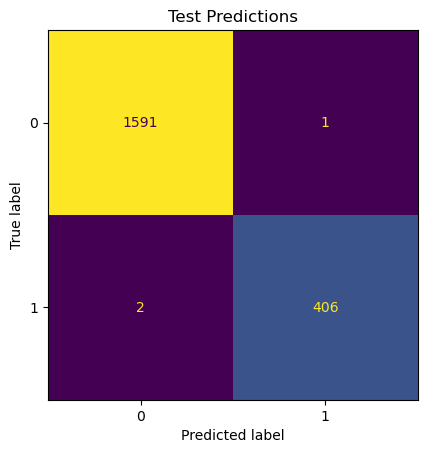

In [379]:
pred(xgb)

In [381]:
feat(xgb)

,Feature,Importance
0,complain,0.965007
1,country_S,0.003281
2,active,0.002998
3,num_products,0.002858
4,country_F,0.002795
5,satisfaction,0.002375
6,age,0.002257
7,card_G,0.002213
8,credit_card,0.001941
9,salary,0.001879


XGBoost classifier ranks features differently than other models with complain still in first but whether or not a customer is from Spain as second most important, and whether or not the customer is active as third most important.

## LightGBM Classifier

In [385]:
# Untuned model

lgb = LGBMClassifier(random_state=42, verbose=-1)

In [387]:
cv(lgb)

Cross-validated recall: 0.9987730061349694


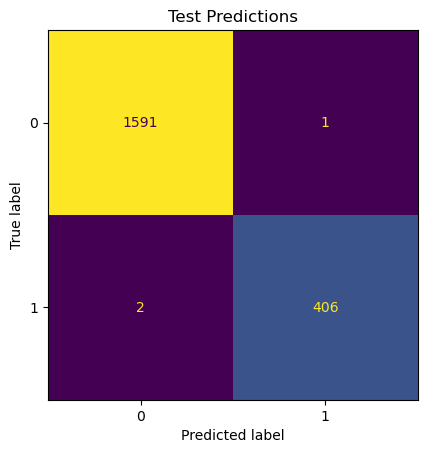

In [389]:
pred(lgb)

In [391]:
feat(lgb)

,Feature,Importance
0,tenure,575
1,points,372
2,satisfaction,313
3,age,292
4,num_products,276
5,balance,185
6,active,161
7,salary,124
8,country_G,114
9,complain,100


The LightGBM classifier is the first model that doesn't list complain as the most important feature. In fact complain is the 10th most important feature! The most important features for this model are tenure, points, and satisfaction.

## CatBoost Classifier

In [395]:
# Untuned model

cb = CatBoostClassifier(random_state=42, verbose=0)

In [397]:
cv(cb)

Cross-validated recall: 0.9987730061349694


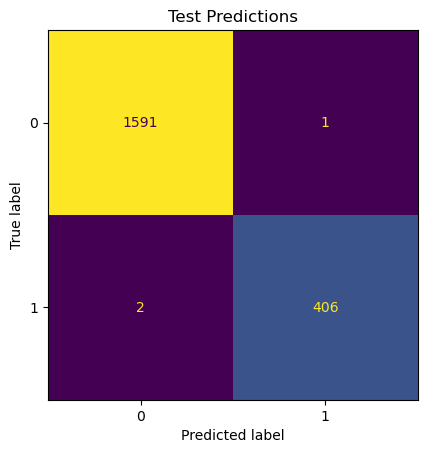

In [399]:
pred(cb)

In [401]:
#Evaluate feature importances

cb_fi = pd.DataFrame({'Feature':X_train.columns, 'Importance':cb.feature_importances_}).sort_values(
                    'Importance', ascending=False).reset_index(drop=True)
cb_fi

,Feature,Importance
0,complain,75.213879
1,age,2.959163
2,tenure,2.882064
3,points,2.848723
4,salary,2.416150
5,num_products,2.333857
6,satisfaction,2.322602
7,balance,1.851612
8,credit_score,1.519033
9,active,1.142911


Similar to random forest and gradient boosting, catboost ranks complain and age as the two most important features. This model, however, places tenure in third.

With the exception of adaboost, our previous 8 models all had the same cross-validated recall scores on the train data, and the same true / false prediction ratios on the test data. As all of these models come from the decision tree family, we will also try out a couple of other model types.

## Logistic Regression Classifier

In [406]:
# Untuned model

lr = LogisticRegression(random_state=42)

Though the logistic regression classifier is sensitive to unscaled features, we need not scale our features here, as the data binning put all values within a close scaling.

In [409]:
cv(lr)

Cross-validated recall: 0.9987730061349694


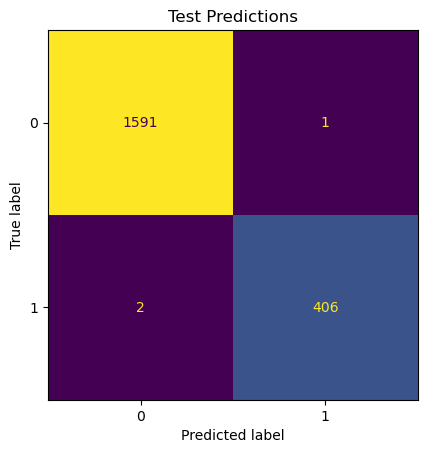

In [411]:
pred(lr)

## Support Vector Machine Classifier

In [418]:
# Untuned model

sv = SVC(random_state=42)

In [420]:
cv(sv)

Cross-validated recall: 0.9987730061349694


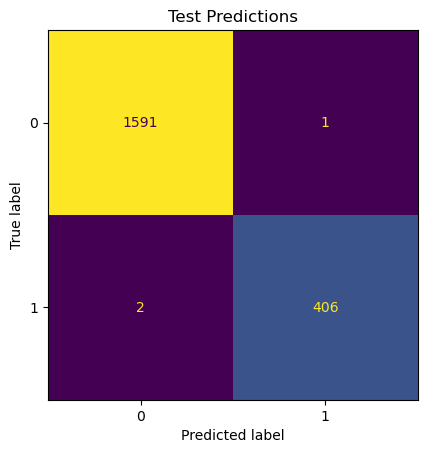

In [422]:
pred(sv)

## Additional EDA

Since 'complain' is overwhelmingly the most important feature across (almost) all models, let's check if there are any churned customers that did not complain. Similarly, we will check if there are any customers that complained but did not churn.

In [563]:
# Total number of customers who churned

tch = df[df['churn']==1].shape[0]

# Churned without complaining

ych_nco = df[(df['churn'] == 1) & (df['complain'] == 0)].shape[0]

# Total number of customers who complained

tco = df[df['complain']==1].shape[0]

# Complained without churning

yco_nch = df[(df['complain'] == 1) & (df['churn'] == 0)].shape[0]

In [565]:
print(f'{ych_nco} / {tch} customers who churned did not complain')
print(f'{yco_nch} / {tco} customers who complained did not churn')

4 / 2038 customers who churned did not complain
10 / 2044 customers who complained did not churn


The takeaway jumps off the page. All but 4 customers who churned had complained. And of all the customers who complained, only 10 of them did not end up churning. This indicates that by far the most important thing for Fairway to do to prevent churn is to improve its complaint resolution. Moreover, Fairway should aim to improve customer support so as to prevent complaints (and hence churn) in the first place. To predict the effect of complaint resolution on churn, let's see compare actual test predictions to predictions on a modified test set with reduced complain values.

In [568]:
# Predictions on initial test set

rf.fit(X_train, y_train)
preds_og = rf.predict(X_test)
print(confusion_matrix(y_test, preds1))

[[1591    1]
 [   2  406]]


The model only has 3 false predictions out of 2000 in the test set. We can be confident that the model predicts accurately.

In [571]:
# Calculate percentage of customers predicted to churn on initial test set

churn_og = len(preds_og[preds_og == 1]) / len(preds_og)

print(f'{round(churn_og*100)}% of customers in the test set were predicted to churn.')

20% of customers in the test set were predicted to churn.


In [593]:
# Calculate percentage of customers predicted to churn if no customers complained

X_test_no_complaints = X_test.copy()
X_test_no_complaints['complain'] = 0
preds_no_complaints = rf.predict(X_test_no_complaints)

churn_no_complaints = len(preds_no_complaints[preds_no_complaints == 1]) / len(preds_no_complaints)

print(f'In a mock scenario with 0 complaints, {round(churn_no_complaints*100)}% of customers were predicted to churn.')

In a mock scenario with 0 complaints, 0% of customers were predicted to churn.


In [595]:
# Calculate percentage of customers predicted to churn if 10% of customers complained

X_test_10_percent = X_test.copy()
X_test_10_percent['complain'] = np.random.choice([0, 1], size=2000, p=[0.9, 0.1])
preds_10_percent = rf.predict(X_test_10_percent)

churn_10_percent = len(preds_10_percent[preds_10_percent == 1]) / len(preds_10_percent)

print(f'In a mock scenario in which 10% of customers complained - selected at random - {round(churn_10_percent*100)}% of customers were predicted to churn.')

In a mock scenario in which 10% of customers complained - selected at random - 10% of customers were predicted to churn.


The examples illustrate that whether a customer churns and whether a customer complains are directly proportional. Thus, to reduce churn by 10%, Fairway must reduce complaints by 10%. But is there more that can be done to locate the issue before a complaint is filed? We will proceed to model without the 'complain' feature, to see if we can better understand the profile of a customer who is likely to churn.

## Summary

We split the Fairway customer sample dataset into an 80% train set and a 20% test set. We explored 10 different classification models' ability to predict customer churn:

- Random Forest
- Extra Trees
- Gradient Boosting
- Hist Gradient Boosting
- AdaBoost
- XGBoost
- LightGBM
- CatBoost
- Logistic Regression
- Support Vector Machine

We identified recall as the ideal performance metric, as the goal is to minimize false negatives so as to make sure that we identify all customers that are likely to churn. Without any hyperparameter tuning, every model had a recall of ~ 99.88% (except for AdaBoost which had a recall of 99.63 %). We identified feature importances for all models and 'complain' was overwhelmingly the most important feature, making it the golden feature of the dataset. Given that this alone provides the clear insight for Fairway's next course of action--improve customer support and complaint resolution(!!)--we will report this insight to stakeholders and share the important finding that:

- only 4 / 2038 churned customers didn't complain
- only 10 / 2044 customers who complained didn't churn
- therefore 'complain' and 'churn' are directly proportional

Moving forward, we will proceed to explore churn prediction without the 'complain' feature, so as to better understand the type of customer that is at risk for churning. We expect model performance to significanly drop without this feature, so we will do our best to mitigate this drop with hyperparameter tuning and by adjusting the probability threshold of our models' churn predicion to be more conservative than the default 50%. See you in Modeling Stage 2.